Import all packages

In [65]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Functions to process 2 different types of data files

In [66]:
def yellow_df(file_path, date_filter, time_filter_start, time_filter_end):
    delimiter = ','
    df = pd.read_csv(file_path, delimiter=delimiter)
    df = df.rename(columns={
        'Position time (UTC)': 'Datetime',
        'Latitude (°)': 'Latitude',
        'Longitude (°)': 'Longitude'
    })
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Date'] = df['Datetime'].dt.date
    df['Time'] = df['Datetime'].dt.time

    new_col = ['Datetime','Date', 'Time', 'Latitude', 'Longitude']
    new_df = df[new_col]
    
    filtered_df = new_df[
        (new_df['Date'] == pd.to_datetime(date_filter).date()) & 
        (new_df['Time'] >= pd.to_datetime(time_filter_start).time()) &
        (new_df['Time'] <= pd.to_datetime(time_filter_end).time())
    ].reset_index(drop=True)
    
    return filtered_df


def white_df(file_path, date_filter, time_filter_start, time_filter_end):
    date_column = 4
    filtered_rows = []

    # Open the input file and process it line by line
    with open(file_path, 'r') as file:
        for line in file:
            columns = line.strip().split()
            if len(columns) >= 7 and columns[date_column] == date_filter:
                filtered_rows.append(columns[4:8])

    df = pd.DataFrame(filtered_rows, columns=['Date', 'Time', 'Latitude', 'Longitude'])

    time_filter_start = pd.to_datetime(f"{date_filter} {time_filter_start}")
    time_filter_end = pd.to_datetime(f"{date_filter} {time_filter_end}")

    # Change format from strings to date/time/numbers
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
    df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
    df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
    df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

    filtered_df = df[(df['Datetime'] >= time_filter_start) & (df['Datetime'] <= time_filter_end)].reset_index(drop=True)

    return filtered_df

Haversine formula to transfer longitudes and latitudes (degrees) to distance between 2 points (meters)

In [67]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    R = 6371.0  # Earth's radius in km

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in km
    distance = R * c

    return distance


Functions to calculate Velocities and Average velocities

In [68]:
def calc_velocities(dataframe):
    distances = []
    time_diffs = []
    velocities = []

    # Ensure there are enough rows to iterate
    if len(dataframe) < 2:
        print("Not enough data to calculate distances and velocities for the file dataset.")
    else:
        for i in range(1, len(dataframe)):
            lat1, lon1 = dataframe.iloc[i - 1][['Latitude', 'Longitude']]
            lat2, lon2 = dataframe.iloc[i][['Latitude', 'Longitude']]

            # Calculate distance using haversine formula (in meters)
            distance_km = haversine(lat1, lon1, lat2, lon2)
            distance_meters = distance_km * 1000
            distances.append(distance_meters)

            # Calculate time difference in seconds
            time_diff = abs((pd.to_datetime(dataframe.iloc[i]['Time'].strftime('%H:%M:%S'), format='%H:%M:%S') -
                             pd.to_datetime(dataframe.iloc[i - 1]['Time'].strftime('%H:%M:%S'), format='%H:%M:%S')).total_seconds())
            time_diffs.append(time_diff)

            # Calculate velocity in m/s
            velocity = distance_meters / time_diff if time_diff != 0 else np.nan
            velocities.append(velocity)

    # Prepare the time data for plotting
    time_values = dataframe['Datetime'].iloc[1:].reset_index(drop=True)
    return velocities, time_values



# Average velocity calculation function
def calc_average_velocity(dataframe):
    if len(dataframe) < 2:
        print("Not enough data to calculate average velocity.")
        return None

    total_distance = 0  # meters
    total_time = 0  # seconds

    for i in range(1, len(dataframe)):
        lat1, lon1 = dataframe.iloc[i - 1][['Latitude', 'Longitude']]
        lat2, lon2 = dataframe.iloc[i][['Latitude', 'Longitude']]

        # Calculate distance using haversine
        distance_km = haversine(lat1, lon1, lat2, lon2)
        distance_meters = distance_km * 1000
        total_distance += distance_meters

        # Calculate time difference
        time_diff = abs((dataframe.iloc[i]['Datetime'] - dataframe.iloc[i - 1]['Datetime']).total_seconds())
        total_time += time_diff

    # Average velocity (m/s)
    average_velocity = total_distance / total_time if total_time != 0 else 0
    return average_velocity

File path to the data files (source folder)

In [69]:
file_path = 'sources\\LCF00386.txt'
filtered_df = yellow_df(file_path, '2024-10-18', '09:18:00', '10:49:00')

file_path2 = 'sources\\DR7160.txt'
filtered_df2 = white_df(file_path2, '2024-10-18', '09:18:00', '10:45:00')

file_path3 = 'sources\\DR9931.txt'
filtered_df3 = white_df(file_path3, '2024-10-18', '09:18:00', '11:02:00')


filtered_df16 = yellow_df(file_path, '2024-10-16', '08:51:00', '10:33:00')

filtered_df16_2 = white_df(file_path2, '2024-10-16', '08:51:00', '10:53:00')

Plotting velocities over time for October 18

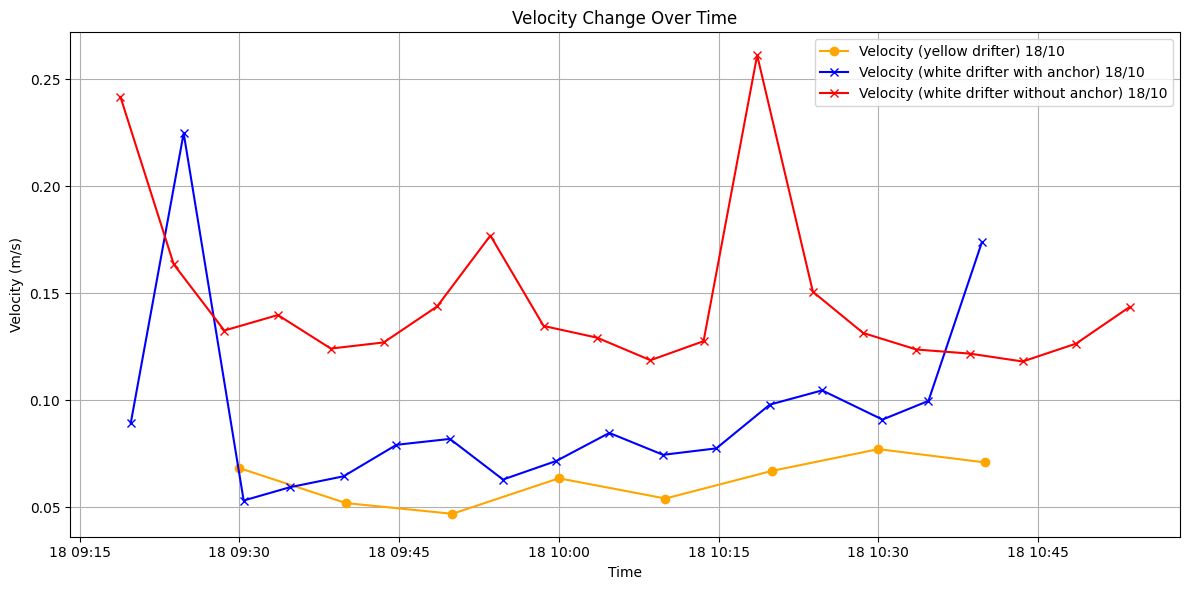

In [70]:
if (filtered_df.empty):
    print("No data available for the specified date - yellow.")
if (filtered_df2.empty):
    print("No data available for the specified date - white 1.")    
if (filtered_df3.empty):
    print("No data available for the specified date - white 2.")        
else:
    time_values, velocities = calc_velocities(filtered_df)
    time_values2, velocities2 = calc_velocities(filtered_df2)
    time_values3, velocities3 = calc_velocities(filtered_df3)


    plt.figure(figsize=(12, 6))

    plt.plot(velocities, time_values, label='Velocity (yellow drifter) 18/10', color='orange', marker='o')
    plt.plot(velocities2, time_values2, label='Velocity (white drifter with anchor) 18/10', color='blue', marker='x')
    plt.plot(velocities3, time_values3, label='Velocity (white drifter without anchor) 18/10', color='red', marker='x')

    # formatting the plot
    plt.title('Velocity Change Over Time')

    plt.xlabel('Time')
    plt.ylabel('Velocity (m/s)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

Plotting velocities over time for October 16

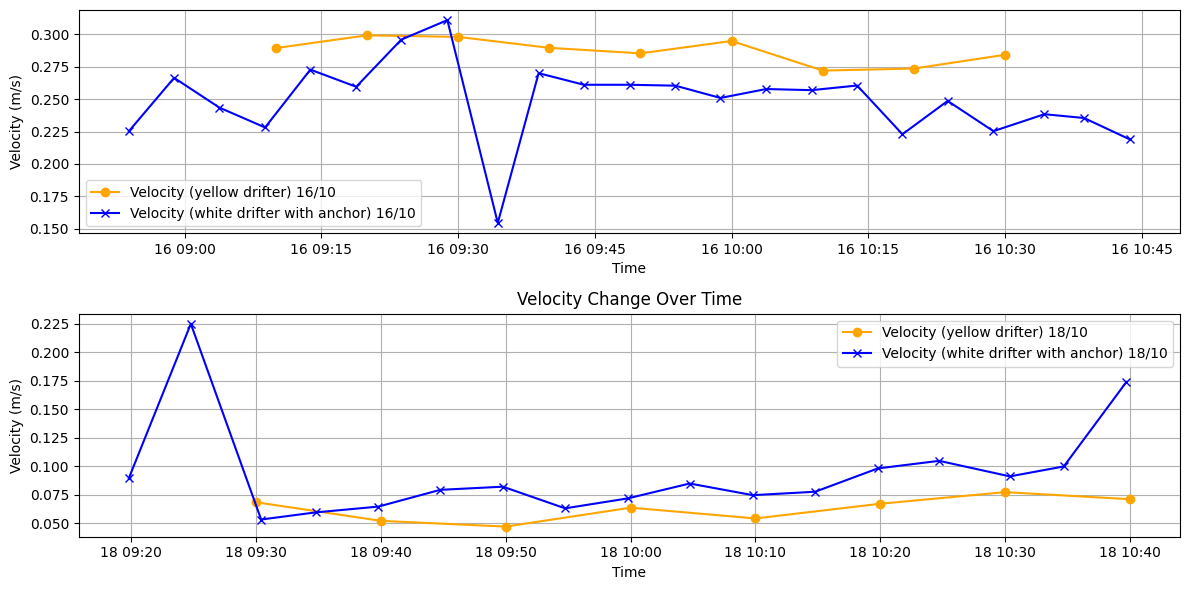

In [71]:
if (filtered_df16.empty):
    print("No data available for the specified date - yellow.")
if (filtered_df16_2.empty):
    print("No data available for the specified date - white 1.")          
else:
    time_values16, velocities16 = calc_velocities(filtered_df16) #yellow 16
    time_values16_2, velocities16_2 = calc_velocities(filtered_df16_2) #white with anchor 16

    fig, axs = plt.subplots(2, 1, figsize=(12, 6))

    # velocity with subplots to compare data with Oct16
    axs[0].plot(velocities16, time_values16, label='Velocity (yellow drifter) 16/10', color='orange', marker='o')  
    axs[0].plot(velocities16_2, time_values16_2, label='Velocity (white drifter with anchor) 16/10', color='blue', marker='x')  


    axs[1].plot(velocities, time_values, label='Velocity (yellow drifter) 18/10', color='orange', marker='o')
    axs[1].plot(velocities2, time_values2, label='Velocity (white drifter with anchor) 18/10', color='blue', marker='x')

    # formatting the plot
    plt.title('Velocity Change Over Time')

    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Velocity (m/s)')
    axs[0].grid()
    axs[0].legend()

    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Velocity (m/s)')
    axs[1].grid()
    axs[1].legend()

    plt.tight_layout()
    plt.show()

Calculate average velocities

In [72]:
average_velocity_yellow = calc_average_velocity(filtered_df)
average_velocity_white = calc_average_velocity(filtered_df2)
average_velocity_white2 = calc_average_velocity(filtered_df3)

# Display results
print(f"Average Velocity (Yellow Drifter): {average_velocity_yellow:.2f} m/s")
print(f"Average Velocity (White Drifter): {average_velocity_white:.2f} m/s")
print(f"Average Velocity (White Drifter without anchor): {average_velocity_white2:.2f} m/s")

average_velocity_yellow16 = calc_average_velocity(filtered_df16)
average_velocity_white16 = calc_average_velocity(filtered_df16_2)

# Display results
print(f"Average Velocity (Yellow Drifter): {average_velocity_yellow16:.2f} m/s")
print(f"Average Velocity (White Drifter): {average_velocity_white16:.2f} m/s")


Average Velocity (Yellow Drifter): 0.06 m/s
Average Velocity (White Drifter): 0.10 m/s
Average Velocity (White Drifter without anchor): 0.15 m/s
Average Velocity (Yellow Drifter): 0.29 m/s
Average Velocity (White Drifter): 0.25 m/s


Drifters Positions October 18

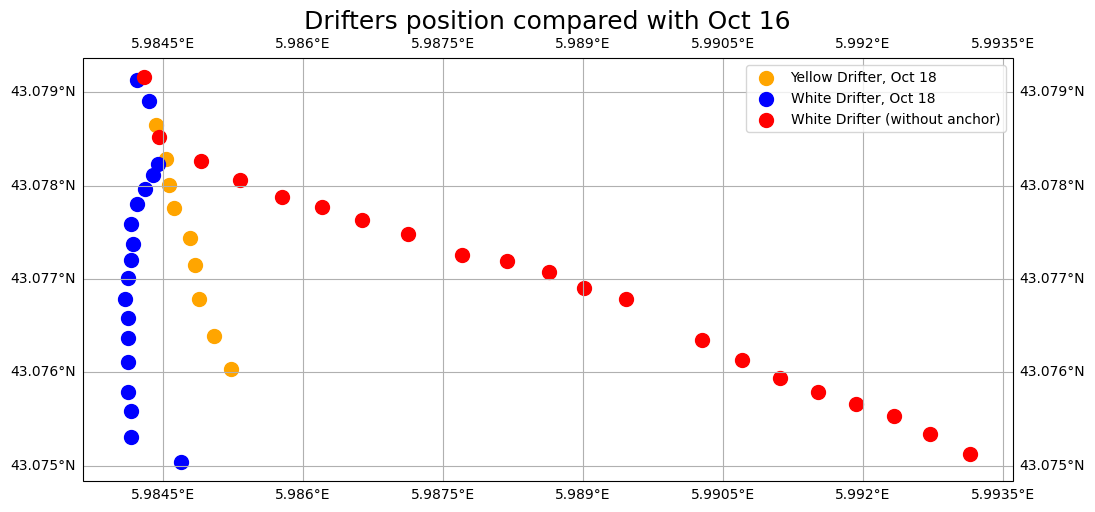

In [73]:
drifter_lats_1 = filtered_df.Latitude
drifter_lons_1 = filtered_df.Longitude

drifter_lats_2 = filtered_df2.Latitude
drifter_lons_2 = filtered_df2.Longitude

drifter_lats_3 = filtered_df3.Latitude
drifter_lons_3 = filtered_df3.Longitude

#Plot drifter positions
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.scatter(drifter_lons_1, drifter_lats_1, color='orange', marker='o', s=100, label='Yellow Drifter, Oct 18')
ax.scatter(drifter_lons_2, drifter_lats_2, color='blue', marker='o', s=100, label='White Drifter, Oct 18')
ax.scatter(drifter_lons_3, drifter_lats_3, color='red', marker='o', s=100, label='White Drifter (without anchor)')

#Add gridlines and legend
ax.gridlines(draw_labels=True)
plt.legend()
plt.title('Drifters position compared with Oct 16', fontsize = 18)

#Display the map with drifter positions
plt.show()

Drifters Positions October 16

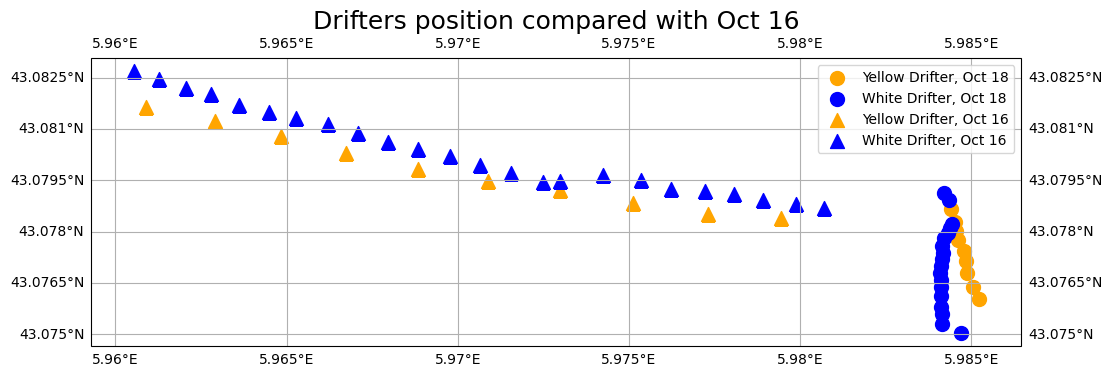

In [74]:
drift_16_lats_1 = filtered_df16.Latitude
drift_16_lons_1 = filtered_df16.Longitude

drift_16_lats_2 = filtered_df16_2.Latitude
drift_16_lons_2 = filtered_df16_2.Longitude

#Plot drifter positions
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.scatter(drifter_lons_1, drifter_lats_1, color='orange', marker='o', s=100, label='Yellow Drifter, Oct 18')
ax.scatter(drifter_lons_2, drifter_lats_2, color='blue', marker='o', s=100, label='White Drifter, Oct 18')
ax.scatter(drift_16_lons_1, drift_16_lats_1, color='orange', marker='^', s=100, label='Yellow Drifter, Oct 16')
ax.scatter(drift_16_lons_2, drift_16_lats_2, color='blue', marker='^', s=100, label='White Drifter, Oct 16')


#Add gridlines and legend
ax.gridlines(draw_labels=True)
plt.legend()
plt.title('Drifters position compared with Oct 16', fontsize = 18)

#Display the map with drifter positions
plt.show()

Drifters Distance

In [75]:
# calculate the distance
print(drifter_lats_1.iloc[0], drifter_lons_1.iloc[0], drifter_lats_1.iloc[-1], drifter_lons_1.iloc[-1])
drifter_1_distance = haversine(drifter_lats_1.iloc[0], drifter_lons_1.iloc[0], drifter_lats_1.iloc[-1], drifter_lons_1.iloc[-1])
print(">>>>>>>>>>>>>>> Drifter 1: ", drifter_1_distance)

print(drifter_lats_2.iloc[0], drifter_lons_2.iloc[0], drifter_lats_2.iloc[-1], drifter_lons_2.iloc[-1])
drifter_2_distance = haversine(drifter_lats_2.iloc[0], drifter_lons_2.iloc[0], drifter_lats_2.iloc[-1], drifter_lons_2.iloc[-1])
print(">>>>>>>>>>>>>>> Drifter 2: ", drifter_2_distance)

print(drifter_lats_3.iloc[0], drifter_lons_3.iloc[0], drifter_lats_3.iloc[-1], drifter_lons_3.iloc[-1])
drifter_3_distance = haversine(drifter_lats_3.iloc[0], drifter_lons_3.iloc[0], drifter_lats_3.iloc[-1], drifter_lons_3.iloc[-1])
print(">>>>>>>>>>>>>>> Drifter 3: ", drifter_3_distance)


43.07865 5.98442 43.07603 5.98523
>>>>>>>>>>>>>>> Drifter 1:  0.29866655209144877
43.07504 5.98469 43.07913 5.98422
>>>>>>>>>>>>>>> Drifter 2:  0.4563865434703356
43.07512 5.99315 43.07916 5.98429
>>>>>>>>>>>>>>> Drifter 3:  0.8483224668638824
